In [1]:
!pip -q install lxml

In [2]:
# Version 67
# From https://ungoogled-software.github.io/ungoogled-chromium-binaries/releases/linux_portable/64bit/
!wget -q https://github.com/Eloston/ungoogled-chromium-binaries/releases/download/67.0.3396.87-2/ungoogled-chromium_67.0.3396.87-2_linux.tar.xz
!tar -xf ungoogled-chromium_67.0.3396.87-2_linux.tar.xz

# From https://chromedriver.storage.googleapis.com/index.html
!wget -q https://chromedriver.storage.googleapis.com/2.41/chromedriver_linux64.zip
!unzip -o chromedriver_linux64.zip -d ./ungoogled-chromium_67.0.3396.87-1_linux

Archive:  chromedriver_linux64.zip
  inflating: ./ungoogled-chromium_67.0.3396.87-1_linux/chromedriver  


In [1]:
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
import re
import os
from lxml import etree
import pandas as pd
import numpy as np

'''
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--incognito')
chrome_options.add_argument('log-level=3')
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--no-sandbox")
chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
chrome_options.add_argument("--width=2560")
chrome_options.add_argument("--height=1440")
browser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
'''

'\nchrome_options = webdriver.ChromeOptions()\nchrome_options.add_argument(\'--headless\')\nchrome_options.add_argument(\'--disable-gpu\')\nchrome_options.add_argument(\'--incognito\')\nchrome_options.add_argument(\'log-level=3\')\nchrome_options.add_argument("--disable-dev-shm-usage")\nchrome_options.add_argument("--no-sandbox")\nchrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"\nchrome_options.add_argument("--width=2560")\nchrome_options.add_argument("--height=1440")\nbrowser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)\n'

In [8]:
class recommendation_panel(object):
    """An expectation for checking that the search tag has a minimum number in the document.
    locator - used to find the element
    min_recommendations - Minimum number of tags that should be found
    returns the WebElement once it has the particular css class
    """
    def __init__(self, locator, min_recommendations = 10):
        self.locator = locator
        self.minrecmd = min_recommendations

    def __call__(self, driver):
        elements = driver.find_elements(*self.locator)   # Finding the referenced element
        if len(elements) >= self.minrecmd:
            return elements
        else:
            return False

class youtube(object):
    # init variables
    driver = None
    source = None
    element = None
    minrecmd = None
    
    def __init__(self,min_recommendations = 5):
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--incognito')
        chrome_options.add_argument('log-level=3')
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--no-sandbox")
        chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
        self.driver = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
        self.minrecmd = min_recommendations
        
    def fetch(self, id):
        # Ask browser to go to url
        #self.driver.execute_script("window.open('');")
        #self.driver.switch_to.window(self.driver.window_handles[1])
        self.driver.set_window_position(0, 0)
        self.driver.set_window_size(1968, 1000)
        self.driver.get(f'https://www.youtube.com/watch?v={id}')
        #self.driver.switch_to.window(driver.window_handles[1])
        # Wait until we have the recommendation panel
        self.element = WebDriverWait(self.driver, 10).until(
            recommendation_panel((By.CSS_SELECTOR, 'span#video-title'),self.minrecmd))
        self.source = self.driver.page_source
        #self.getscreenshot()
        #self.driver.close()
        #self.driver.switch_to.window(self.driver.window_handles[0])
        return self.element is not None
    
    def getsource(self):
        if self.source:
            return self.source
        else:
            return 'Empty buffer'#self.driver.page_source
    
    def getscreenshot(self):
        self.driver.save_screenshot('test.png')
        return 'Done'
  
    def getrecommend(self):
        html = etree.HTML(self.source)
        id = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
        title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
        channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
        result = pd.DataFrame(zip(id,title,channel),columns=['ID','TITLE','CHANNEL'])
        return result
    
    def transcript(self,id='c-7YqBrtuNQ'):
        resp = requests.get(f'https://hierogly.ph/api/transcribe?v={id}',headers={'User-Agent':'Mozilla/5.0'})
        result = re.sub(r'\[[a-zA-Z0-9,.:\s]*\]','',resp.json()['text'])
        return result


In [9]:
yt = youtube(20)

In [12]:
yt.fetch('wE5PaUvvG-U')

True

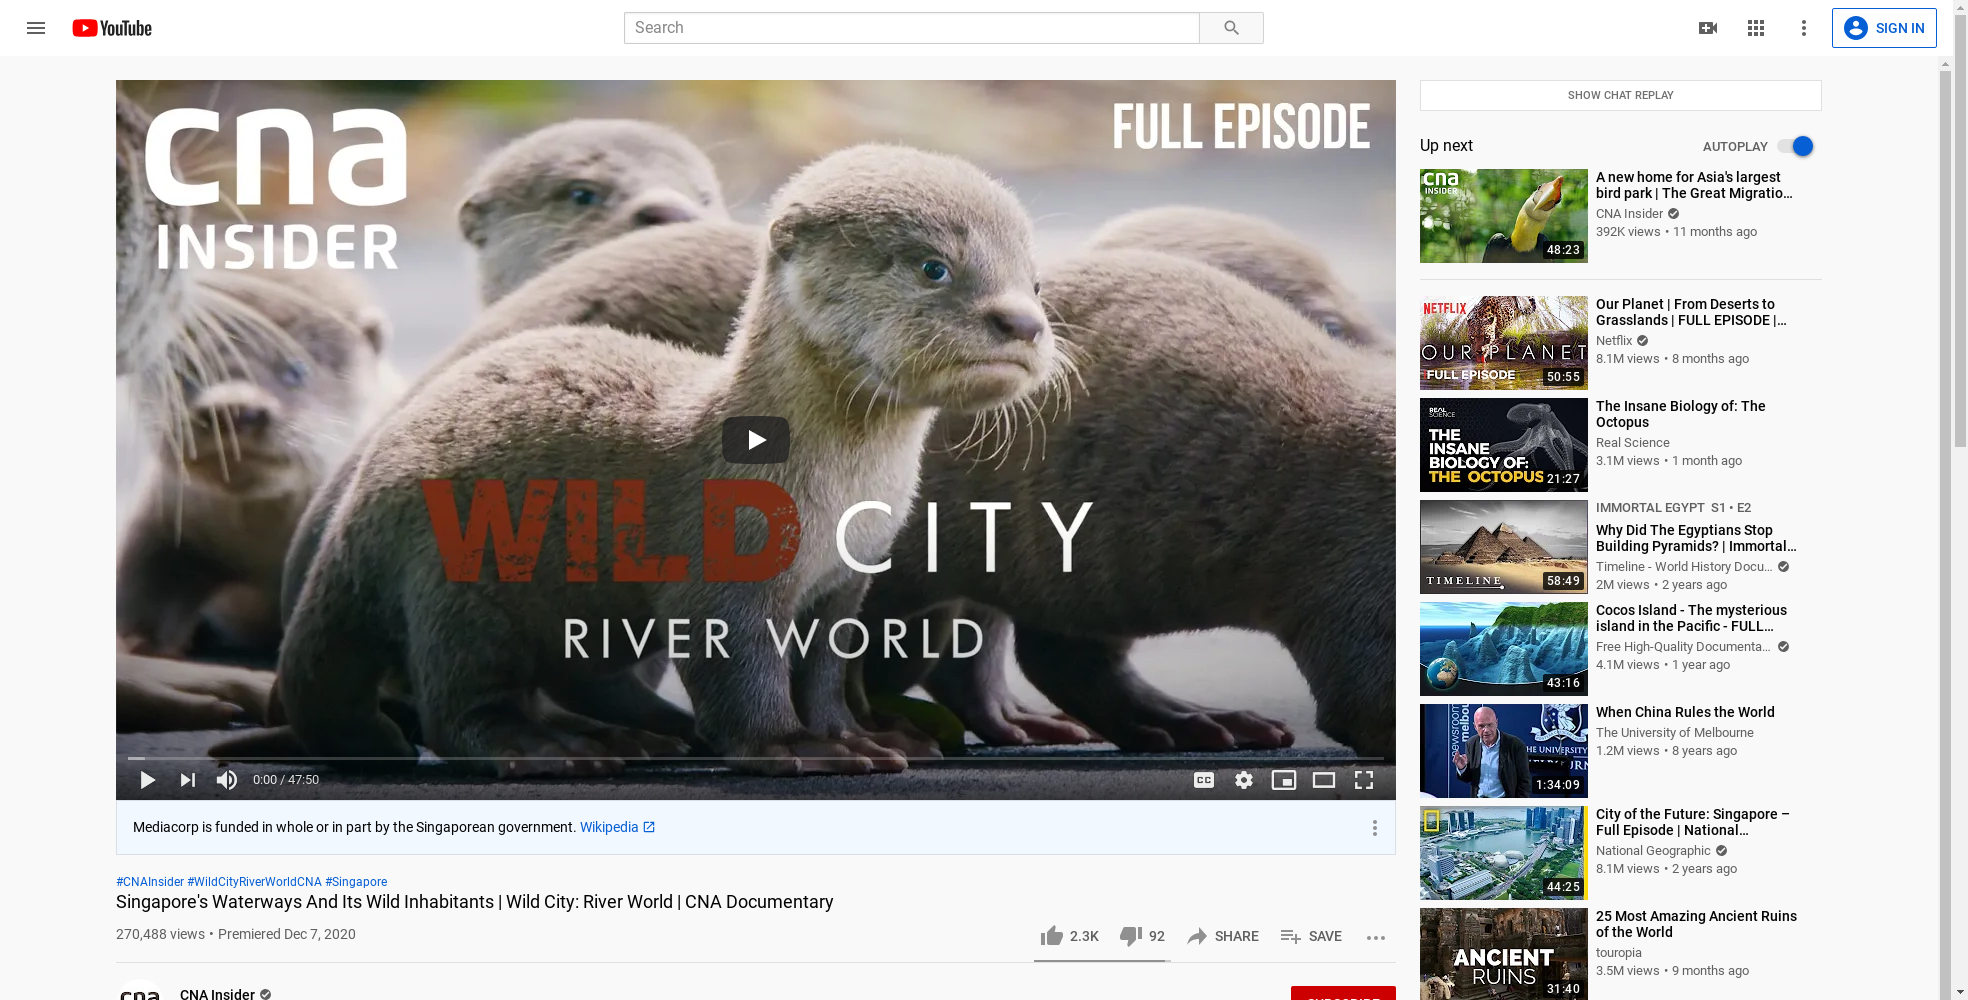

In [14]:
from IPython.display import Image, HTML
yt.getscreenshot()
Image('test.png')

In [11]:
yt.getrecommend()

,ID,TITLE,CHANNEL
0,xi6r3hZe5Tg,City of the Future: Singapore – Full Episode |...,National Geographic
1,d2CoZQcRJ14,What does it take to maintain Singapore's Jewe...,CNA
2,ETLVqETJAFQ,This Airport Has Its Own Island | Super Struct...,Spark
3,-obKX-mqjXQ,Tutankhamun's Treasures (Full Episode) | Lost ...,National Geographic
4,jB2Z9PA7iKI,Dubai. Luxury life tour. Big Episode.,Anton somewhere
5,f8bygjApyM0,National Geographic Megastructures: Delhi IGI ...,Delhi Airport
6,7OMxBlK46wY,Yellowstone (Full Episode) | America's Nationa...,National Geographic
7,0ULzxD3w_c8,MEGACITIES of the World (Season 1 - Complete),TDC
8,1jFMroHSi0Y,Engineering Connections: Burj Al Arab Hotel (R...,Reel Truth Science Documentaries
9,dQf_vE7tOlw,Engineering Connections: Earthquake Proof Brid...,Reel Truth Science Documentaries


In [22]:
yt.source

'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" style="font-size: 10px;font-family: Roboto, Arial, sans-serif;" lang="en"><head><!-- Shady DOM styles for dom-module --><!-- Shady DOM styles for array-selector --><!-- Shady DOM styles for custom-style --><!-- Shady DOM styles for dom-bind --><!-- Shady DOM styles for dom-if --><!-- Shady DOM styles for dom-repeat --><!-- Shady DOM styles for app-drawer --><style scope="app-drawer">app-drawer {\n  position: fixed;\n        \n        z-index: 1;\n        top: -120px;\n        right: 0;\n        bottom: -120px;\n        left: 0;\n\n        visibility: hidden;\n\n        transition-property: visibility;\n}\n\napp-drawer[opened] {\n  visibility: visible;\n}\n\napp-drawer[persistent] {\n  width: var(--app-drawer-width, 256px);\n}\n\napp-drawer[persistent][position=left] {\n  right: auto;\n}\n\napp-drawer[persistent][position=right] {\n  left: auto;\n}\n\n#contentContainer.app-drawer {\n  position: absolute;\n        top: 0;\n      

In [19]:
yt.transcript('llh52RktRxU')

"Changi Airport, Singapore, one of the largest transportation hubs in Asia and voted the best airport in the world, is about to launch what's been touted as an industry game-changer. The ambition we have set for force are presented terminal 4 with full automation. Passengers will be able to serve themselves from check-in to boarding today. Changi is one step closer to changing the aviation model. How do you create something for that moment that you didn't expect, but to deliver the airport's latest terminal? The team must conquer the unfamiliar. We need to green up 50,000 square meters of greenery. It is five football fields using cutting-edge technology. They are breaking new ground, so we're actually lifting up a small car yeah to redefine what air travel is all about. Expectations are very high. Everyone chun-hee to continue to be best at what in the world , tiny tropical island logistics hub and financial powerhouse. Singapore is also home to Changi Airport for six years in a row, 

In [53]:
text = yt.transcript('xi6r3hZe5Tg')

In [55]:
re.sub(r'\[[a-zA-Z0-9,.:\s]*\]','',text)

"The paradigm has shifted, the world is accelerating. The science fiction of yesterday is rapidly becoming the science fiction's of right. Now, how do we withstand the tectonic shifts in the world around us? How does a society thrive where the world economy is undergoing constant disruption? When information is moving at the speed of light, there are places that are ahead of the curve. City is building the tools for tomorrow, . We want to create innovations that have a real way impact. One day single pole can be self-sustained in food production. You are looking at the development of Singapore 40 years ahead of time. This city could be a model that wants to come. This is the city of the future. Singapore. The future of the world lies in its urban environments. More than half the world's population live in cities, and that number is growing. This rapid influx of people creates possibility, but it also creates challenges. How can the cities of today grow and thrive to become the places w

In [8]:
html = etree.HTML(yt.driver.page_source)

In [9]:
## Get the IDs from all the anchors
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]

['ayvV45hAwJY',
 'hWyusr0e6sg',
 '3G1EyvRZmOs',
 'jqNhov14bjc',
 '5ZpaqAYGPgE',
 'D5T4gT9WNYo',
 'j8-JSIw_-vE',
 'yp_7d3CLCCU',
 'B4HCEhS5al8',
 'H_HHYk1eb_s',
 'uDFUqnkm6Ak',
 'bPBJJ-lxsXA',
 'xi6r3hZe5Tg',
 'BlQ3yuUmBiw',
 'IJyNoJCAuzA',
 'WEVT9wXV2Ds',
 'Dl856YM_krU',
 'bYkm7jBNDZI',
 'mszarMOK_28',
 '588oc9-Tm1s']

In [10]:
# Recommended Video Channels
[x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]

['CNA',
 'CNA Insider',
 'The University of Melbourne',
 'RTHK 香港電台',
 'Institute of Policy Studies (IPS), Singapore',
 'govsg',
 'NextDayBetter',
 'Grantmakers In Aging (GIA)',
 'PBS NewsHour',
 'CNA',
 'NPT Reports',
 'TEDx Talks',
 'National Geographic',
 'Living Big In A Tiny House',
 'Inspiritory',
 'South China Morning Post',
 'BRIC TV',
 'CNA Insider',
 'CNA',
 'euronews (in English)']

In [11]:
# Recommended Video IDs
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//span[@id='video-title']/../..")]

['ayvV45hAwJY',
 'hWyusr0e6sg',
 '3G1EyvRZmOs',
 'jqNhov14bjc',
 '5ZpaqAYGPgE',
 'D5T4gT9WNYo',
 'j8-JSIw_-vE',
 'yp_7d3CLCCU',
 'B4HCEhS5al8',
 'H_HHYk1eb_s',
 'uDFUqnkm6Ak',
 'bPBJJ-lxsXA',
 'xi6r3hZe5Tg',
 'BlQ3yuUmBiw',
 'IJyNoJCAuzA',
 'WEVT9wXV2Ds',
 'Dl856YM_krU',
 'bYkm7jBNDZI',
 'mszarMOK_28',
 '588oc9-Tm1s']

In [12]:
# Recommended Video Titles
[x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]

['SINGAPORE: Factors to make ageing a success',
 "Looking After Helen | Singapore's Elderly Poor",
 'When China Rules the World',
 'Hong Kong Connection：Ageing In Place',
 'Singapore Perspectives 2020 "Politics" (Panel I)',
 'Govt prepared for challenges of an ageing population',
 'Aging & Alone: Asian American living alone in New York City',
 'Social isolation  Impact and Age Friendly Interventions',
 'Seniors Hold on to Urban Independence Into Old Age',
 'CNA | On The Red Dot | S7 E13 - Going green with grandma',
 'Loneliness & Isolation | Aging Matters | NPT Reports',
 'The Secret to Successful Aging | Cathleen Toomey | TEDxPiscataquaRiver',
 'City of the Future: Singapore – Full Episode | National Geographic',
 'Tiny House Designed To Be Elderly / Disability / Mobility Friendly',
 'EMPATHY - BEST SPEECH OF ALL TIME By Simon Sinek | Inspiritory',
 'Who cares for the carers looking after Hong Kong’s elderly people?',
 'Yiddish-Speaking Brooklyn | On The Grid with Zephyr Teachout | Ep

In [9]:
vid = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
pd.DataFrame(zip(vid,title,channel),columns=['ID','TITLE','CHANNEL'])

,ID,TITLE,CHANNEL
0,ayvV45hAwJY,SINGAPORE: Factors to make ageing a success,CNA
1,hWyusr0e6sg,Looking After Helen | Singapore's Elderly Poor,CNA Insider
2,tALSvwS1XAM,Japan's Demographic Time Bomb | Insight | Full...,CNA
3,j8-JSIw_-vE,Aging & Alone: Asian American living alone in ...,NextDayBetter
4,5ZpaqAYGPgE,"Singapore Perspectives 2020 ""Politics"" (Panel I)","Institute of Policy Studies (IPS), Singapore"
5,kUY2EkkChzE&list,Mix - CGTN,YouTube
6,uDFUqnkm6Ak,Loneliness & Isolation | Aging Matters | NPT R...,NPT Reports
7,D5T4gT9WNYo,Govt prepared for challenges of an ageing popu...,govsg
8,Dl856YM_krU,Yiddish-Speaking Brooklyn | On The Grid with Z...,BRIC TV
9,hZ34ZyQonT4,Loneliness - The Elderly Epidemic,Ross McAuley


In [37]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [139]:
transcript('rb_adz0tkOw')

"Both of us, we plant a lot of strawberries la on each other's lands. What * screams * Hi, I'm Bolin, I'm Qing, I'm Peps Hi, I'm Leah, and this is Zula ChickChats. Okay, hi guys welcome to today's episode of ChickChats. Why Are you all very nervous? Yes, this is my first time on ChickChats Welcome And today's episode we'll be talking about being in the grey area as much requested from the comments section below. Ah So we hear you okay, we will do this episode for you guys. So my first question to you guys, then, is what happened. Okay, whoever wants can share first la What happened. Bolin, Let's start with Bolin. No Qing should start because she's the new person. Why me? Oh my god? Yes, What happened. I met the person through an app Okay, So we hit off like we talk, then after that move to Telegram. But the thing right we went out for so many times right. The places we go to right were like-, not the kind of place that you and your friends would go to. For example, For example, I need 

In [122]:
transcript('5L31Wbrg7tE')

"On one of the days um, we were supposed to have a date .... He came to my house like downstairs. Then I no time to draw eyebrows no time to draw anything right. Then we [ sat ] at the lamp post. There [, I made ] sure to choose the dimmest lamppost Hi. I ’ m Julian Hi. I ’ m Amanda Hi. I ’ m John Hi. I ’ m Leah and this is Zula ChickChats Hi guys welcome to today. ’ s, episode of Zula ChickChats And today we ’ re gon na be talking about- the honeymoon phase in relationships. We have 3 people over here to share uh- their honeymoon phases in their relationships. So…. The first Can you: why Can you explain what the honeymoon phase is I ...? What do you mean You don, ’ t know I ’ m married. I forgot about it. It ’ s been a long time ago. Okay, so the honeymoon phase, I guess, would be the period before your relationship starts getting serious, All the butterflies, all the romantic gestures, Oh ..., For the first question: maybe we ’ ll, let the audience know for you guys. How long have yo

In [140]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [145]:
transcript('mPHGGxZwICI')

"My name is I've been working for about two years. My name is Rob. I'Ve been working for about two years, six years, plus I think five years plus I'm very sure, let's see God my location off just nice kata-kata and they realize okay might as well. We just did I just graduated. Yes, I think two years ago yeah - and I guess it just seemed like a natural information from that February. For the column, one poet a key numbers, a thousand by hello, I'm Hansel - I just graduated from in yet last year, and now I'm doing an internship of jewelry come and your student, your tree, we have been together what six? Yes, I think with us always day. Video, what does the you need to be married before you can apply for the blueblack all controller? I mean you're gon na collect the key. Oh boss, you don't need to be married, like yeah, you can apply first, then you get true or false. It is possible to play pain, zero cash yeah. You can actually go share without paying any cash. It wasn't actually, when w